In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import TruncatedSVD
import random
import seaborn as sns
import os.path as path
import os
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt # graphs plotting
from Bio import SeqIO # some BioPython that will come in handy
%matplotlib inline

from matplotlib import rc
# for Arial typefont
matplotlib.rcParams['font.family'] = 'Arial'


## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# matplotlib.rcParams['mathtext.fontset'] = 'cm'

## for LaTeX typefont
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'

## for another LaTeX typefont
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# rc('text', usetex = True)

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title

Taken from [Zhang Lab](https://zhanglab.ccmb.med.umich.edu/FASTA/),
see also [FASTA Substitution Codes](https://web.cas.org/help/BLAST/topics/codes.htm) 
and [Codes Used in Sequence Description](https://www.ddbj.nig.ac.jp/ddbj/code-e.html#amino-1).

FASTA format is a text-based format for representing either nucleotide sequences or peptide sequences, in which base pairs or amino acids are represented using single-letter codes. A sequence in FASTA format begins with a single-line description, followed by lines of sequence data. The description line is distinguished from the sequence data by a greater-than (">") symbol in the first column. It is recommended that all lines of text be shorter than 80 characters in length.
An example sequence in FASTA format is:

>S|spike_protein|MG996765|AWV66922.1|A0A3G1RFS9|P138/72|NA|1972|Horse|Switzerland|NA|Equine_torovirus
MFLCFCAATVLCFWINSGGADVVPNGTLIFSEPVPYPFSLDVLRSFSQHVVLRNKRAVTTISWSYSYQIT
TSSLSVNSWYVTFTAPLGWNYYTGQSFGTVLNQNAMMRASQSTFTYDVISYVGQRPNLDCQVNSLVNGGL
DGWYSTVRVDNCFNAPCHVGGRPGCSIGIPYMSNGVCTRVLSTTQSPGLQYEIYSGQQFAVYQITPYTQY


Sequences are expected to be represented in the standard IUB/IUPAC amino acid and nucleic acid codes, with these exceptions:
lower-case letters are accepted and are mapped into upper-case;
a single hyphen or dash can be used to represent a gap of indeterminate length;
in amino acid sequences, U and * are acceptable letters (see below).
any numerical digits in the query sequence should either be removed or replaced by appropriate letter codes (e.g., N for unknown nucleic acid residue or X for unknown amino acid residue).
The nucleic acid codes are:

        A --> adenosine           M --> A C (amino)
        C --> cytidine            S --> G C (strong)
        G --> guanine             W --> A T (weak)
        T --> thymidine           B --> G T C
        U --> uridine             D --> G A T
        R --> G A (purine)        H --> A C T
        Y --> T C (pyrimidine)    V --> G C A
        K --> G T (keto)          N --> A G C T (any)
                                  -  gap of indeterminate length
The accepted amino acid codes are:

    A ALA alanine                         P PRO proline
    B ASX aspartate or asparagine         Q GLN glutamine
    C CYS cystine                         R ARG arginine
    D ASP aspartate                       S SER serine
    E GLU glutamate                       T THR threonine
    F PHE phenylalanine                   U SCY selenocysteine
    G GLY glycine                         V VAL valine
    H HIS histidine                       W TRP tryptophan
    I ILE isoleucine                      Y TYR tyrosine
    K LYS lysine                          Z GLX glutamate or glutamine
    J XLE leucine or isoleucine           X XAA any
    L LEU leucine                         
    M MET methionine                      *     translation stop
    N ASN asparagine                      -     gap of indeterminate length

# **Reading the data**

In [3]:
# Read the fasta-file and create a dictionary of its protein sequences

input_file_name = "Sequences.fasta"

# The fasta defline (name of a sequence) has the following format:
# Strain Name | Accession Number | Host Species | Virus Species) 
sequences_dictionary = {sequence.id : sequence.seq for sequence in SeqIO.parse(input_file_name,'fasta')}

In [4]:
# From the newly formed sequences_dictionary, we create 3 lists:
# a list of deflines,
# a list of sequences,
# and a list of target values

# We want to mark all sequences that belong to the viruses that can infect humans as 1 (i.e., target = 1), 
# all other sequences as 0 (i.e., target = 0)

human_virus_species_set =  {'Human_coronavirus_NL63', 'Betacoronavirus_1', 
                            'Human_coronavirus_HKU1', 'Severe_acute_respiratory_syndrome_related_coronavirus', 
                            'SARS_CoV_2', 'Human_coronavirus_229E', 'Middle_East_respiratory_syndrome_coronavirus'}

deflines = [entry for entry in sequences_dictionary.keys()]             # create a list of deflines
protein_sequences = [entry for entry in sequences_dictionary.values()]  # create a list of protein sequences 


# we assign 1 iff a virus species is one from the 7 human-infective

targets = [0]*len(deflines)
for i, defline in enumerate(deflines):
    for virus_species in human_virus_species_set:
        if virus_species in defline:
            targets[i] = 1   

In [5]:
# We create a class fasta_sequence so that we would be able to use the sequence data easily 

class fasta_sequence:
    def __init__(self, defline, sequence, target, type_of_encoding = "onehot"):
        
        # we read the input data
        
        self.defline = defline
        self.sequence = sequence
        self.target = target
        
        # and create more descriptions of the input data
        
        # report the strain name (the 1st fiel of the defline)
        self.strain_name = defline.split("|")[0]
        # report the accession number (the 2nd fiel of the defline)
        self.accession_number = defline.split("|")[1]        
        # report the host species (the 3rd fiel of the defline)
        self.host_species = defline.split("|")[2]    
        # report the virus species (the 4th fiel of the defline)
        self.virus_species = defline.split("|")[3]
        
        
# We convert a string with the alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-' 
# into either a list mapping chars to integers (called integer encoding),
# or a sparce list. In the latter, each amino acid is represented as an one-hot vector of length 25, 
# where each position, except one, is set to 0.  E.g., alanine is encoded as 10000000000000000000, 
# cystine is encoded as 01000000000000000000
# See the full table above.
# Symbol '-' is encoded as a zero-vector.

        def encoding(sequence, type_of_encoding):

            # define universe of possible input values
            alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-'
            # define a mapping of chars to integers
            char_to_int = dict((c, i) for i, c in enumerate(alphabet))


            # integer encoding
            integer_encoded = [char_to_int[char] for char in sequence]

            # one-hot encoding
            onehot_encoded = list()
            for value in integer_encoded:
                letter = [0 for _ in range(len(alphabet)-1)]
                if value != len(alphabet)-1:
                    letter[value] = 1
                onehot_encoded.append(letter)
            flat_list = [item for sublist in onehot_encoded for item in sublist]

            if type_of_encoding == "onehot":
                return flat_list
            else:
                return integer_encoded
            
        #  we use the encoding function to create a new attribute for the sequence -- its encoding        
        self.encoded = encoding(sequence, type_of_encoding)

In [6]:
# we create a list of sequences as objects of the class fasta_sequence
# all sequences are encoded with one-hot encoding (it is the default option of the constructor of the class)
sequences = []
for i in range(0, len(deflines)):
    current_sequence = fasta_sequence(deflines[i],protein_sequences[i],targets[i])
    sequences.append(current_sequence)

# **Getting familiar with the data**

In [7]:
# create a list of strain names (the 4th fiel of the defline)
virus_species = [entry.virus_species for entry in sequences]    
# convert the list of strain names into a set 
virus_species_set = set(virus_species)

if "NA" in virus_species_set:
    print("There are", len(virus_species_set)-1, "entries of the virus species in our dataset") # we don't count the NA entry
else:
    print("There are", len(virus_species_set), "entries of the virus species in our dataset") # we count all entries
    
print("The list of all varieties of the virus species in our dataset:\n", virus_species_set)


There are 61 entries of the virus species in our dataset
The list of all varieties of the virus species in our dataset:
 {'Camel_coronavirus_HKU23', 'Bat_coronavirus_BM48_31/BGR/2008', 'Pipistrellus_bat_coronavirus_HKU5', 'Hedgehog_coronavirus1', 'SADS_CoV', 'Falcon_coronavirus_UAE-HKU27', 'HKU4_related_bat_coronavirus', 'Rhinolophus_bat_coronavirus_HKU2', 'Betacoronavirus_1', 'Bat_Coronavirus_HKU10', 'Porcine_coronavirus_HKU15', 'Bat_coronavirus_CDPHE15', 'Rabbit_coronavirus_HKU14', 'Rhinolophus_bat_coronavirus_HKU32', 'Avian_coronavirus', 'Bottlenose_dolphin_coronavirus', 'NL63-related_bat_coronavirus', 'Human_coronavirus_NL63', 'Munia_coronavirus_HKU13', 'Betacoronavirus_HKU24', 'Hipposideros_pomona_bat_coronavirus_CHB25', 'Murine_coronavirus', 'Bat_coronavirus_HKU10', 'SARS_CoV_2', 'Alphacoronavirus_1', 'Bulbul_coronavirus_HKU11', 'Bat_coronavirus_1B', 'Miniopterus_bat_coronavirus1', 'White_eye_coronavirus_HKU16', 'Middle_East_respiratory_syndrome_coronavirus', 'Human_coronavirus_H

In [8]:
idx = pd.Index(virus_species) # creates an index which allows counting the entries easily
print('Here are all of the viral species in the dataset: \n', len(idx),"entries in total")
print(idx.value_counts())

Here are all of the viral species in the dataset: 
 1238 entries in total
Avian_coronavirus                               282
Porcine_epidemic_diarrhea_virus                 268
Betacoronavirus_1                               184
Middle_East_respiratory_syndrome_coronavirus    147
Porcine_coronavirus_HKU15                        66
                                               ... 
Ferret_enteric_coronavirus                        1
White_eye_coronavirus_HKU16                       1
Miniopterus_bat_coronavirus1                      1
Erinaceus_hedgehog_coronavirus_HKU31              1
Common_moorhen_coronavirus_HKU21                  1
Length: 61, dtype: int64


In [9]:
viral_species_top = []
for sequence in sequences:
    if sequence.virus_species == 'Avian_coronavirus':
        viral_species_top.append('Avian CoV')
    elif sequence.virus_species == 'Porcine_epidemic_diarrhea_virus':
        viral_species_top.append('PEDV')
    elif sequence.virus_species == 'Betacoronavirus_1':
        viral_species_top.append('BCoV-1')
    elif sequence.virus_species == 'Middle_East_respiratory_syndrome_coronavirus':
        viral_species_top.append('MERS')
    elif sequence.virus_species == 'Porcine_coronavirus_HKU15':
        viral_species_top.append('HKU15')
    elif sequence.virus_species == 'SARS_CoV_2':
        viral_species_top.append('SARS-2')
    else:
        viral_species_top.append('Other CoVs')

In [10]:
labels_species = ['Avian CoV',  'PEDV',  'BCoV-1',
                  'MERS', 'HKU15', 'SARS-2', 'Other CoVs']

overall_size = len(viral_species_top)
sizes_species = [viral_species_top.count('Avian CoV') / overall_size, 
                 viral_species_top.count('PEDV') / overall_size,          
                 viral_species_top.count('BCoV-1') / overall_size,
                 viral_species_top.count('MERS') / overall_size, 
                 viral_species_top.count('HKU15') / overall_size, 
                 viral_species_top.count('SARS-2') / overall_size,
                 viral_species_top.count('Other CoVs') / overall_size],

In [11]:
# create a list of strain names of the viruses that can affect humans
human_virus_species = [entry.virus_species for entry in sequences if 'Human' in entry.defline]
# turn this list into a set
human_virus_species_set = set(human_virus_species)

print("There are", len(human_virus_species_set), "unique virus human-infective species in our dataset") # we don't count the NA entry
print("The list of all unique human-infective virus species in our dataset:\n", human_virus_species_set)

There are 7 unique virus human-infective species in our dataset
The list of all unique human-infective virus species in our dataset:
 {'Human_coronavirus_HKU1', 'Human_coronavirus_NL63', 'Human_coronavirus_229E', 'Severe_acute_respiratory_syndrome_related_coronavirus', 'SARS_CoV_2', 'Betacoronavirus_1', 'Middle_East_respiratory_syndrome_coronavirus'}


In [12]:
# How many viral sequences are marked as infective to humans?
# To answer it, we can simply count 1's in the target list:

print("We have got", targets.count(1), "entries of human related CoVs") 

We have got 463 entries of human related CoVs


In [13]:
# create a list of human related sequences

human_related_sequences = [entry for entry in sequences if entry.target == 1] 

In [14]:
# create a list of strain names (the 4th field of the defline)

virus_species_human = [entry.virus_species for entry in human_related_sequences]  
idx_human = pd.Index(virus_species_human) # creates an index which allows counting the entries easily
idx_human.value_counts()

Betacoronavirus_1                                        184
Middle_East_respiratory_syndrome_coronavirus             147
SARS_CoV_2                                                48
Human_coronavirus_NL63                                    26
Human_coronavirus_HKU1                                    21
Severe_acute_respiratory_syndrome_related_coronavirus     19
Human_coronavirus_229E                                    18
dtype: int64

In [15]:
hosts_dictionary = {"Avians" : {'Turkey', 'White_Rumped_Munia', 'Bulbul', 'Pheasant', 'Night_Heron', 'Teal', 'White_Eye', 
                                'White_eye', 'Duck', 'Dabbling_Duck', 'Pigeon', 'Chicken', 'Sparrow', 'Common_Moorhen', 
                                'Common_moorhen',
                                'Magpie_Robin', 'Magpie_robin', 'Quail', 'Falcon', 'Bustard', 'Shelduck', 'Guinea_Fowl',
                                'Grey_Backed_Thrush'},
                    "Fish" : {'Blicca_Bjoerkna_L.', 'Fathead_Minnow','Fathead_minnow'},
                    "Reptiles": {'Python','Turtle'},
                    "Bats" : {'Bat','Rhinolophus_blasii','bat_BF_258I','bat_BF_506I'},
                    "Camels": {'Camel'},
                    "Human": {'Human'},
                    "Swine": {'Swine','Pig','Sus_scrofa_domesticus'},
                    "Other mammals": {'Anteater', 'Hedgehog', 'Horse', 'Mink', 'Alpaca', 'Ferret', 'Rabbit',
                                      'Buffalo', 'Goat', 'Chimpanzee', 'Dog', 'Cattle', 'Rat', 'Mouse', 'Cat', 'Dolphin',
                                     'Mus_Musculus__Severe_Combined_Immunedeficiency__Scid___Female__6_8_Weeks_Old__Liver__Sample_Id:_E4m31',
                                     },
                    "Unknowns": {'NA', 'Unknown'}
                   }

                
multi_targets = []

for sequence in sequences:
    for category, set_of_hosts in hosts_dictionary.items():
        if sequence.host_species in set_of_hosts:
                 multi_targets.append(category)

                   

In [16]:
labels_hosts = ["Swine", "Avians", "Human", "Bats", "Camels", "Other mammals"]
full_labels_hosts = ["Swine 29.6\%(367)", "Avians 24.2\%(300)", "Human 22.6\%(280)", 
               "Bats 7.5\%(93)", "Camels 6.7\%(83)", "Other mammals 9.3\%(115)"]
overall_size = len(multi_targets)
sizes_hosts = [multi_targets.count("Swine") / overall_size,
               multi_targets.count("Avians") / overall_size,    
               multi_targets.count("Human") / overall_size, 
               multi_targets.count("Bats") / overall_size, 
               multi_targets.count("Camels") / overall_size,
               multi_targets.count("Other mammals") / overall_size]

In [17]:
def move_it(p,pctdists):
    for t,d in zip(p, pctdists):
        xi,yi = t.get_position()
        ri = np.sqrt(xi**2+yi**2)
        phi = np.arctan2(yi,xi)
        x = d*ri*np.cos(phi)
        y = d*ri*np.sin(phi)
        t.set_position((x,y))

c:\users\kuzmi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


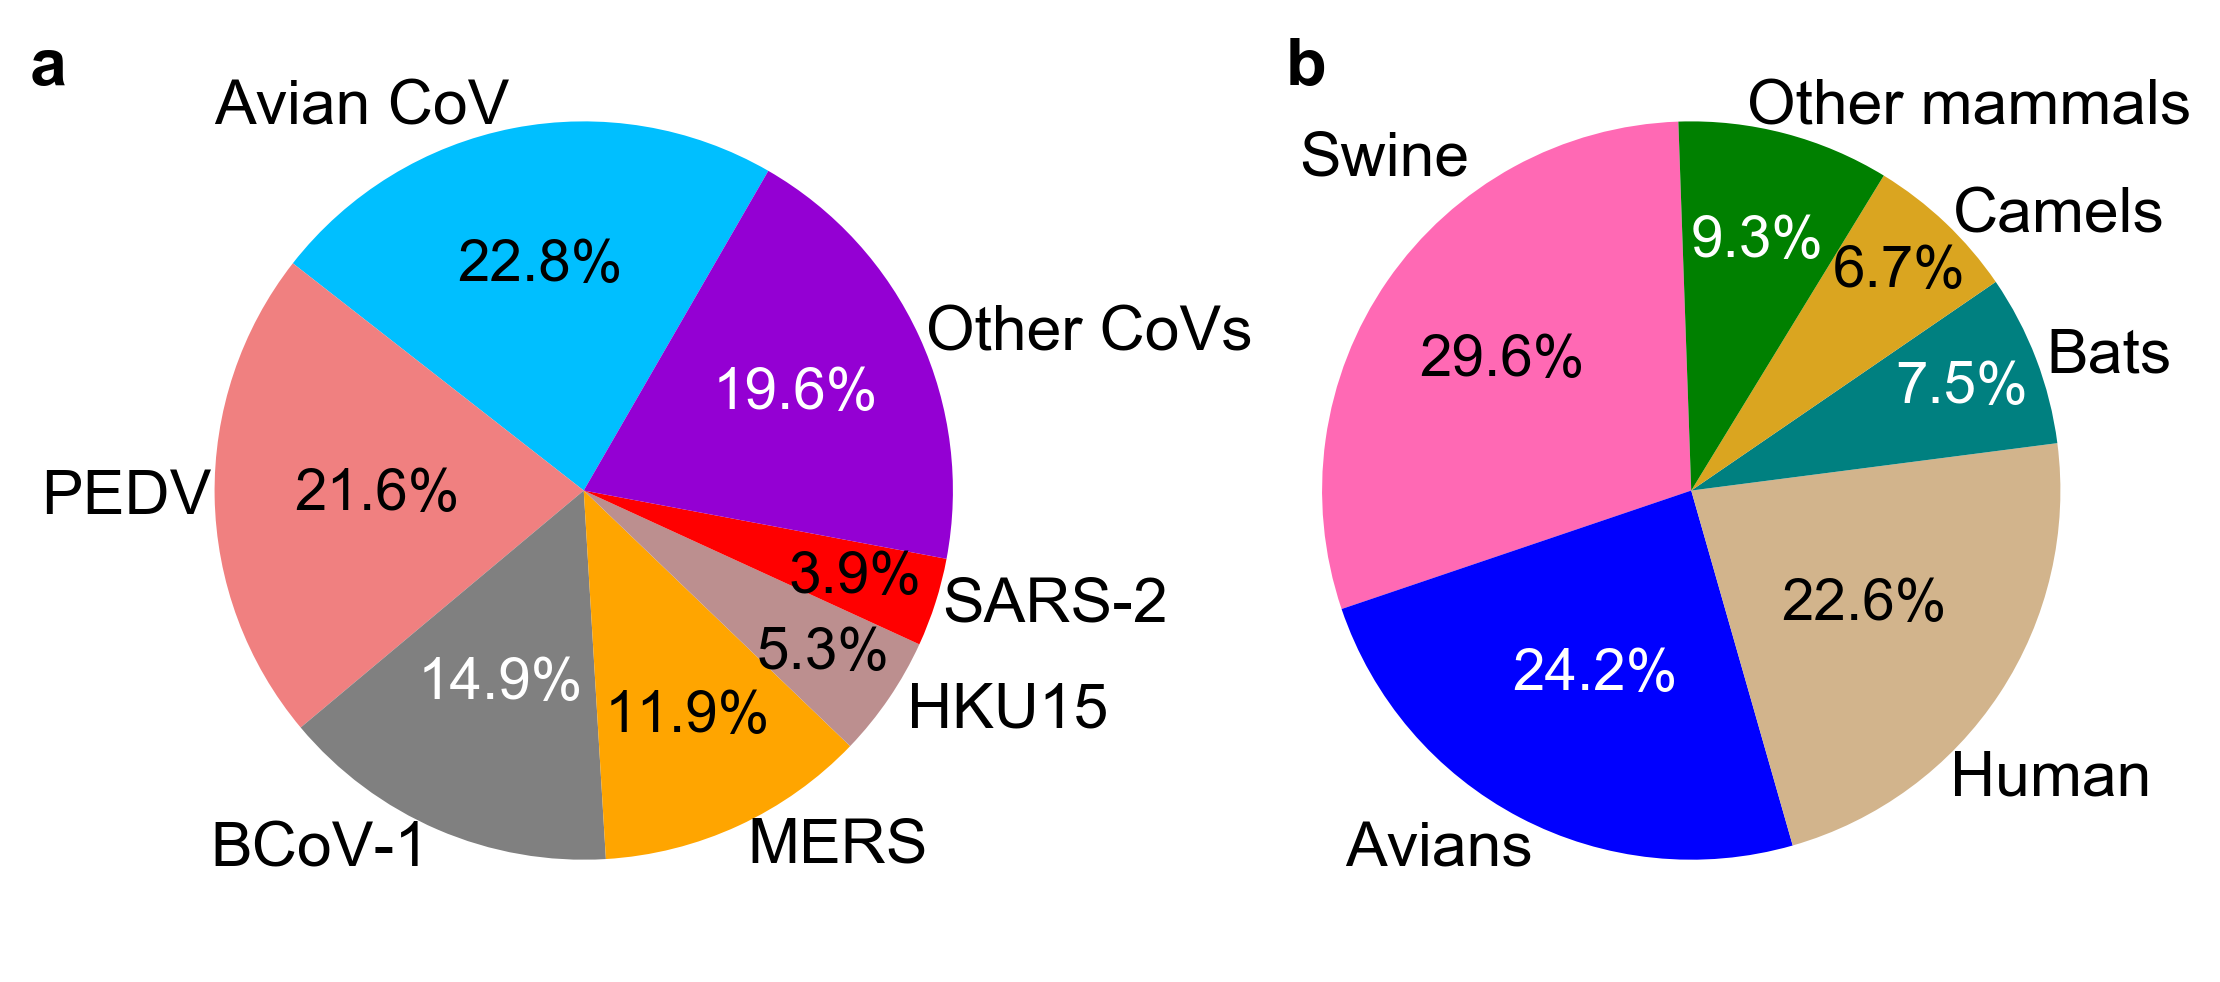

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.2, 3.6), dpi=300)

colors_species = ["deepskyblue", "lightcoral", "grey", "orange", "rosybrown", "red", "darkviolet"] 

_,lbl_1,p_1 = ax1.pie(sizes_species,  labels = labels_species, 
#         autopct = lambda p : '{:.1f}\%({:,.0f})'.format(p,p * overall_size/100),
        autopct = lambda p : '{:.1f}%'.format(p), colors = colors_species,
        startangle = 60, pctdistance =  0.70, labeldistance = 0.98,   textprops={'fontsize': 14})
pct_dists_1 = [.89, .8, .81, .96, 1.12, 1.1, .9]
label_dists_1 = [1.08, 1.03, 1.08, 1.08, 1.08, 1.04, 1.04]
move_it(p_1,pct_dists_1)
move_it(lbl_1,label_dists_1)
for i in range(len(labels_species)):
    lbl_1[i].set_fontsize(15)
p_1[2].set_color('white')
p_1[6].set_color('white')

colors_hosts = ["hotpink", "blue", "tan", "teal", "goldenrod", "green"] 

_,lbl_2,p_2 =ax2.pie(sizes_hosts,  labels = labels_hosts, colors = colors_hosts,
#         autopct = lambda p : '{:.1f}\%({:,.0f})'.format(p,p * overall_size/100),
        autopct = lambda p : '{:.1f}%'.format(p),
        startangle = 92, pctdistance =  0.70, labeldistance = 1.03, textprops={'fontsize': 14})
pct_dists_2 = [.89, .8, .8, 1.12, 1.17, 1.0]
move_it(p_2,pct_dists_2)
lbl_2[0].set_position((-0.6, 0.9))
p_2[1].set_color('white')
lbl_2[1].set_position((-0.43, -0.97))
lbl_2[2].set_position((0.7, -0.78))
p_2[3].set_color('white')
lbl_2[5].set_position((0.15, 1.04))
p_2[5].set_color('white')
for i in range(len(labels_hosts)):
    lbl_2[i].set_fontsize(15)

ax1.text(-1.5, 1.1, 'a', fontsize=16, weight='bold')
ax2.text(-1.1, 1.1, 'b', fontsize=16, weight='bold')

plt.subplots_adjust(left=0.04, right=0.98, bottom=0, top=1)
plt.show()
fig.savefig('Pies.eps')

In [19]:
targets_mammals = []

for target in multi_targets:
    if target == "Bats" or target == "Camels" or target == "Human" or target == "Swine" or target == "Other mammals":
        targets_mammals.append(1)
    else:
        targets_mammals.append(0)       

In [20]:
print(targets_mammals.count(1))
print(targets_mammals.count(0))

938
300


In [21]:
targets_avian_vs_swine = []
sequences_avian_vs_swine = []

for target, sequence in zip(multi_targets,sequences):
    if target == "Avians":
        targets_avian_vs_swine.append(1)
        sequences_avian_vs_swine.append(sequence)
    elif target == "Swine":
        targets_avian_vs_swine.append(0)   
        sequences_avian_vs_swine.append(sequence)

In [22]:
print(len(targets_avian_vs_swine))
print(targets_avian_vs_swine.count(1))

667
300


In [23]:
coro_dictionary = {"Alpha" : {'Bat_Coronavirus_HKU10','Human_coronavirus_NL63','NL63-related_bat_coronavirus',
                              'Porcine_enteric_alphacoronavirus','Swine_acute_diarrhea_syndrome',
                              'Miniopterus_bat_coronavirus1',
                              'Miniopterus_bat_coronavirus_HKU8','Hipposideros_pomona_bat_coronavirus_CHB25',
                              'Feline_alphacoronavirus1','Porcine_epidemic_diarrhea_virus',
                              'Swine_acute_diarrhea_syndrome_HKU2_related','SADS_CoV',
                              'Bat_coronavirus_CDPHE15', 'Rhinolophus_bat_coronavirus_HKU32',
                              'Minacovirus','Nyctacovirus','Rhinolophus_bat_coronavirus_HKU2','Alphacoronavirus_1',
                              'Bat_coronavirus_1B','Bat_coronavirus_HKU10','229E_related_bat_coronavirus',
                              'Human_coronavirus_229E','Ferret_enteric_coronavirus','Ferret_systemic_coronavirus',
                              'Ferret_coronavirus','Bat_coronavirus_CDPHE15/USA/2006'},
                   "Beta":   {'Pangolin_coronavirus','Erinaceus_hedgehog_coronavirus_HKU31',
                              'Hedgehog_coronavirus1', 'Rabbit_coronavirus_HKU14','Camel_coronavirus_HKU23',
                              'Betacoronavirus_HKU24','Betacoronavirus_1','Severe_acute_respiratory_syndrome_related_coronavirus',
                              'Middle_East_respiratory_syndrome_coronavirus','SARS_CoV_2','Human_coronavirus_HKU1',
                              'Pipistrellus_bat_coronavirus_HKU5','Tylonycteris_bat_coronavirus_HKU4','Rousettus_bat_coronavirus_HKU9', 
                              'Bat_coronavirus_BM48_31/BGR/2008', 'Murine_coronavirus',
                              'Betacoronavirus_Erinaceus/VMC/DEU/2012','HKU4_related_bat_coronavirus', 'HKU5_related_bat_coronavirus'},
                   "Gamma":  {'Bottlenose_dolphin_coronavirus','Beluga_Whale_coronavirus_SW1','Avian_coronavirus'},
                   "Delta":  {'Thrush_coronavirus_HKU12', 'Munia_coronavirus_HKU13', 'Porcine_coronavirus_HKU15',
                              'Falcon_coronavirus_UAE-HKU27','Houbara_coronavirus_UAE-HKU28', 'Pigeon_coronavirus_UAE-HKU29',
                              'Quail_coronavirus_UAE-HKU30','Sparrow_deltacoronavirus_HKU17', 'Sparrow_coronavirus_HKU17',
                              'White_eye_coronavirus_HKU16','Night_heron_coronavirus_HKU19','Magpie_robin_coronavirus_HKU18',
                              'Wigeon_coronavirus_HKU20','Common_moorhen_coronavirus_HKU21', 'Bulbul_coronavirus_HKU11'},
                   "Unclassified": {'Bat_coronavirus'},
                   "Serpentovirinae": {'Ball_python_nidovirus1'},
                   "Torovirinae": {'unclassified_Torovirinae','Goat_torovirus','Bovine_torovirus','Equine_torovirus',
                                   'Porcine_torovirus'},
                   "Piscanivirinae": {'White_bream_virus','Fathead_minnow_nidovirus1','Fathead_minnow_nidovirus'},
                   "Unknowns": {'NA', 'Unknown'}
                  }
     
            
coro_types = []

for sequence in sequences:
    for genus_or_family, set_of_species in coro_dictionary.items():
        if sequence.virus_species in set_of_species:
            if genus_or_family in {"Serpentovirinae","Torovirinae","Piscanivirinae","Pimfabavirus"}:
                taxonomy_label = "Tobaniviridae"
            else:
                taxonomy_label = genus_or_family
            coro_types.append(taxonomy_label)

# Encoding

In [24]:
# for a list of sequences, returns a list of encoded sequences and a list of targets

def EncodeAndTarget(list_of_sequences):
    # encoding the sequences
    list_of_encoded_sequences = [entry.encoded for entry in list_of_sequences]
    # creating lists of targets
    list_of_targets = [entry.target for entry in list_of_sequences]
    return list_of_encoded_sequences, list_of_targets   

In [25]:
# encoding ALL the sequences

encoded_sequences = [entry.encoded for entry in sequences]

### The 7 (463) vs Not the 7 (775) // total = 1238 (all sequences)

In [26]:
encoded_sequences, targets = EncodeAndTarget(sequences)

In [27]:
print(targets.count(1),targets.count(0))

463 775


### Mammals (938) vs Not Mammals (300) // total = 1238 (all sequences)

In [28]:
# encoded_sequences_cor, targets_mammals

In [29]:
print(targets_mammals.count(1),targets_mammals.count(0))

938 300


### Avians (300) vs Swine (367) // total = 667

In [30]:
encoded_sequences_avian_vs_swine, _ = EncodeAndTarget(sequences_avian_vs_swine)

# encoded_sequences_avian_vs_swine, targets_avian_vs_swine

In [31]:
print(targets_avian_vs_swine.count(1),targets_avian_vs_swine.count(0))

300 367


### Human related sequences

In [32]:
# obtaining encoded sequences

encoded_human_related_sequences, _ = EncodeAndTarget(human_related_sequences)

In [33]:
# naming viruses from the set of "7 human related" properly

def rename_the_seven(list_of_names):
    for i in range(0,len(list_of_names)):
        if list_of_names[i] == 'Betacoronavirus_1':
            list_of_names[i] = 'BCoV-1' # 'HCoV-OC43' is here as well
        if list_of_names[i] == 'Middle_East_respiratory_syndrome_coronavirus':
            list_of_names[i] = 'MERS' 
        if list_of_names[i] == 'Severe_acute_respiratory_syndrome_related_coronavirus':
            list_of_names[i] = 'SARS' 
        if list_of_names[i] == 'SARS_CoV_2':
            list_of_names[i] = 'SARS-2'         
        if list_of_names[i] == 'Human_coronavirus_NL63':
            list_of_names[i] = 'NL63'         
        if list_of_names[i] == 'Human_coronavirus_HKU1':
            list_of_names[i] = 'HKU1'                                        
        if list_of_names[i] == 'Human_coronavirus_229E':
            list_of_names[i] = '229E'            
    return list_of_names

### SARS-2

In [34]:
#  [f(x) if condition else g(x) for x in sequence]
#  [f(x) for x in sequence if condition]

targets_SARS2 = [1 if entry.virus_species == 'SARS_CoV_2' else 0 for entry in sequences] 

> # **Reducing a number of components in the input vectors**

In [35]:
# calculates explained variance for each of elements in number_of_components
def list_of_explained_variances(sequences, number_of_components, to_print = False):
    levels = []
    for i in number_of_components:
        svd = TruncatedSVD(n_components = i, n_iter = 7, random_state = 42)
        X = svd.fit_transform(sequences)
        explained_variances = svd.explained_variance_ratio_
        
        # the sum of all included explained variances 
        the_level = explained_variances.sum()
        if to_print == True:
            print(i, the_level)
        levels.append(the_level)
    return levels

In [36]:
number_of_components = list(range(2,101)) # + [150,200,300,500,1000]
# levels = list_of_explained_variances(encoded_sequences, number_of_components, to_print = True)

In [37]:
levels = [0.25568409905818756, 0.44835892689840623, 0.6018402162226205, 0.6705062930628497, 0.7288286305830591,
          0.7623875594347068,  0.7831795349144737,  0.7981023640683405, 0.8109759929413681, 0.8220331172526931,
          0.8316326722903065,  0.8406260094981872,  0.8491999504869686, 0.856724533941381,  0.8631591270600852,
          0.8691493583894242,  0.874887292574866,   0.880376514421534,  0.885072601055676,  0.8894505888723757,
          0.8936121028641761,  0.8970579825078968,  0.9003408860162803, 0.9033564667555427, 0.9063106913107046,
          0.9087989806221994,  0.9110682375817961,  0.9133029739209915, 0.9154109910463663, 0.9173093681019192,
          0.9191867468126194,  0.9209814786741014,  0.922737974318336,  0.924484096766618,  0.9260347052098663,
          0.9275723987600493,  0.9290969614554543,  0.930519930739189,  0.9318197314834873, 0.9330409929938127,
          0.9341964014109178,  0.9352905644008496,  0.9363458021111587, 0.9373679842904428, 0.9383612106449231,
          0.9393043794108098,  0.9402047799012239,  0.9411136269194047, 0.9419813987873142, 0.942854391258279,
          0.9436912128971707,  0.9444906115022896,  0.945267800999359,  0.9460378024288508, 0.9467801174602527,
          0.9474884855097307,  0.9482354400439916,  0.9489499403543746, 0.9496818795540687, 0.9503761108538649,
          0.9510470729139154,  0.9517340639271392,  0.952427344400935,  0.9530758520840343, 0.9537140096245186,
          0.9543590911612557,  0.9549775420790156,  0.9555886153387624, 0.956212093228864,  0.95679081132169,
          0.9573873987436247,  0.9579831154927835,  0.9585519667639217, 0.9591219594134277, 0.959690036934241,
          0.9602284070604666,  0.9607852941178018,  0.9613262855887439, 0.9618267324571558, 0.9623601384474844,
          0.9628506479889509,  0.9633561676394138,  0.9638526902144948, 0.9643442431654274, 0.9647890301792906,
          0.9652672883520134,  0.965718737990766,   0.966167118702543,  0.9666112669276075, 0.9670311238808057,
          0.967447522736929,   0.9678470477010803,  0.968242709512709,  0.9686392379490667, 0.9690090919329103,
          0.9693917860964814,  0.969763417361457,   0.9701463791649364, 0.9705097191512718]

In [38]:
levels_avians_swines = [0.5843292926215152, 0.7360487820595264, 0.7865633943825971, 0.8146355582654068,
    0.8366529042229119, 0.8519090781094912, 0.8630759014744932, 0.8736034602376127, 0.8836095988719994,
    0.8914813538788849, 0.8992483666557767, 0.9048476083358611, 0.9092725149604689, 0.9131339591400256,
    0.9160895388317495, 0.9187583171264788, 0.9213225134219253, 0.9236554456613032, 0.9259071486143706,
    0.9279897106764058, 0.929884672192865,  0.9317516383337449, 0.9335784139149846, 0.9353616314550811,
    0.9371103692890506, 0.9388184750246779, 0.9404729375404672, 0.9420292366385107, 0.9435296741876844,
    0.9450030486603849, 0.9464363181673947, 0.9478212790454881, 0.9490699049013214, 0.9502097718446201,
    0.9513010705950339, 0.9523407993989035, 0.9533154448337906, 0.9542767695263039, 0.9552370927314313,
    0.9561603047559464, 0.9570207214521873, 0.9578602978566124, 0.9586651402863886, 0.9594176576022599,
    0.9601377893689811, 0.9608536379634265, 0.9615422838843144, 0.9622006631312804, 0.9628075334141409,
    0.9634010791035519, 0.9639662130376263, 0.9645178883577689, 0.9650674212465945, 0.9655991792125314,
    0.9661252906132405, 0.9666195252810365, 0.9671201158130315, 0.9676105022455125, 0.9680835258999889,
    0.9685454713641438, 0.9690071944485699, 0.969462863949829,  0.9698992914592833, 0.9703339308986958,
    0.9707378501689922, 0.9711342133016129, 0.97149442155459,   0.9718522035453632, 0.9721957750098723,
    0.9725380614440162, 0.9728644750140858, 0.9732000404866078, 0.9735161883003692, 0.9738265322569368,
    0.9741337930582267, 0.9744251003509791, 0.9747187038290875, 0.9750034685913787, 0.9752731308989149,
    0.9755557505432924, 0.9758196005007004, 0.9760806431953771, 0.9763356301770603, 0.9765850065509829,
    0.9768314027591131, 0.9770754783677561, 0.9773152704866129, 0.9775451997315476, 0.9777771892220384,
    0.9780046610857172, 0.9782186715268261, 0.9784436273996902, 0.9786526534367731, 0.9788549617144275,
    0.9790625916470079, 0.97927355011726,   0.9794814117764385, 0.9796809090877655, 0.9798779175952045]

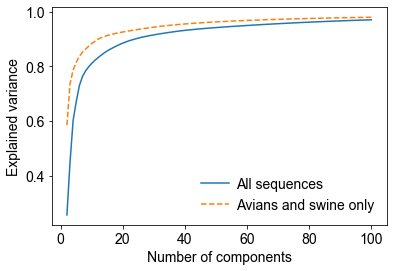

In [39]:
import matplotlib as mpl
mpl.rcParams['legend.handletextpad'] = 0.5

plt.plot(number_of_components, levels, label="All sequences")
plt.plot(number_of_components, levels_avians_swines, '--', label="Avians and swine only")
plt.xlabel("Number of components")
# proportion of the data dispersion which has been "explained" 
# the proportion to which a i components account for the variation of the original data
plt.ylabel("Explained variance") 
plt.legend(frameon=False)
plt.savefig('Explained_variance.eps')

### SVD applied to all sequences and avians+swines

In [40]:
svd = TruncatedSVD(n_components = 50, n_iter = 7, random_state = 42)
X_50 = svd.fit_transform(encoded_sequences)

# the command below is the same as
# explained_variances = np.var(X_50, axis=0) / np.var(encoded_sequences, axis=0).sum()
explained_variances = svd.explained_variance_ratio_

# the sum of all included explained variances 
the_level = explained_variances.sum()

In [41]:
svd_avians_swines = TruncatedSVD(n_components = 50, n_iter = 7, random_state = 42)
X_50_avians_swines = svd_avians_swines.fit_transform(encoded_sequences_avian_vs_swine)

explained_variances_avians_swines = svd_avians_swines.explained_variance_ratio_

> # **Visualization with t-SNE**

In [42]:
from sklearn.manifold import TSNE

# We embed all our sequences into 2D vectors with help of TSNE
X_embedded = TSNE(n_components = 2, perplexity = 30, random_state = 1).fit_transform(encoded_sequences)

In [43]:
# We embed human related sequences into 2D vectors with help of TSNE
X_embedded_human = TSNE(n_components = 2, perplexity = 30, random_state = 1).fit_transform(encoded_human_related_sequences)

In [44]:
import matplotlib as mpl
mpl.rcParams['legend.handletextpad'] = -0.4
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.loc'] = 'lower left'

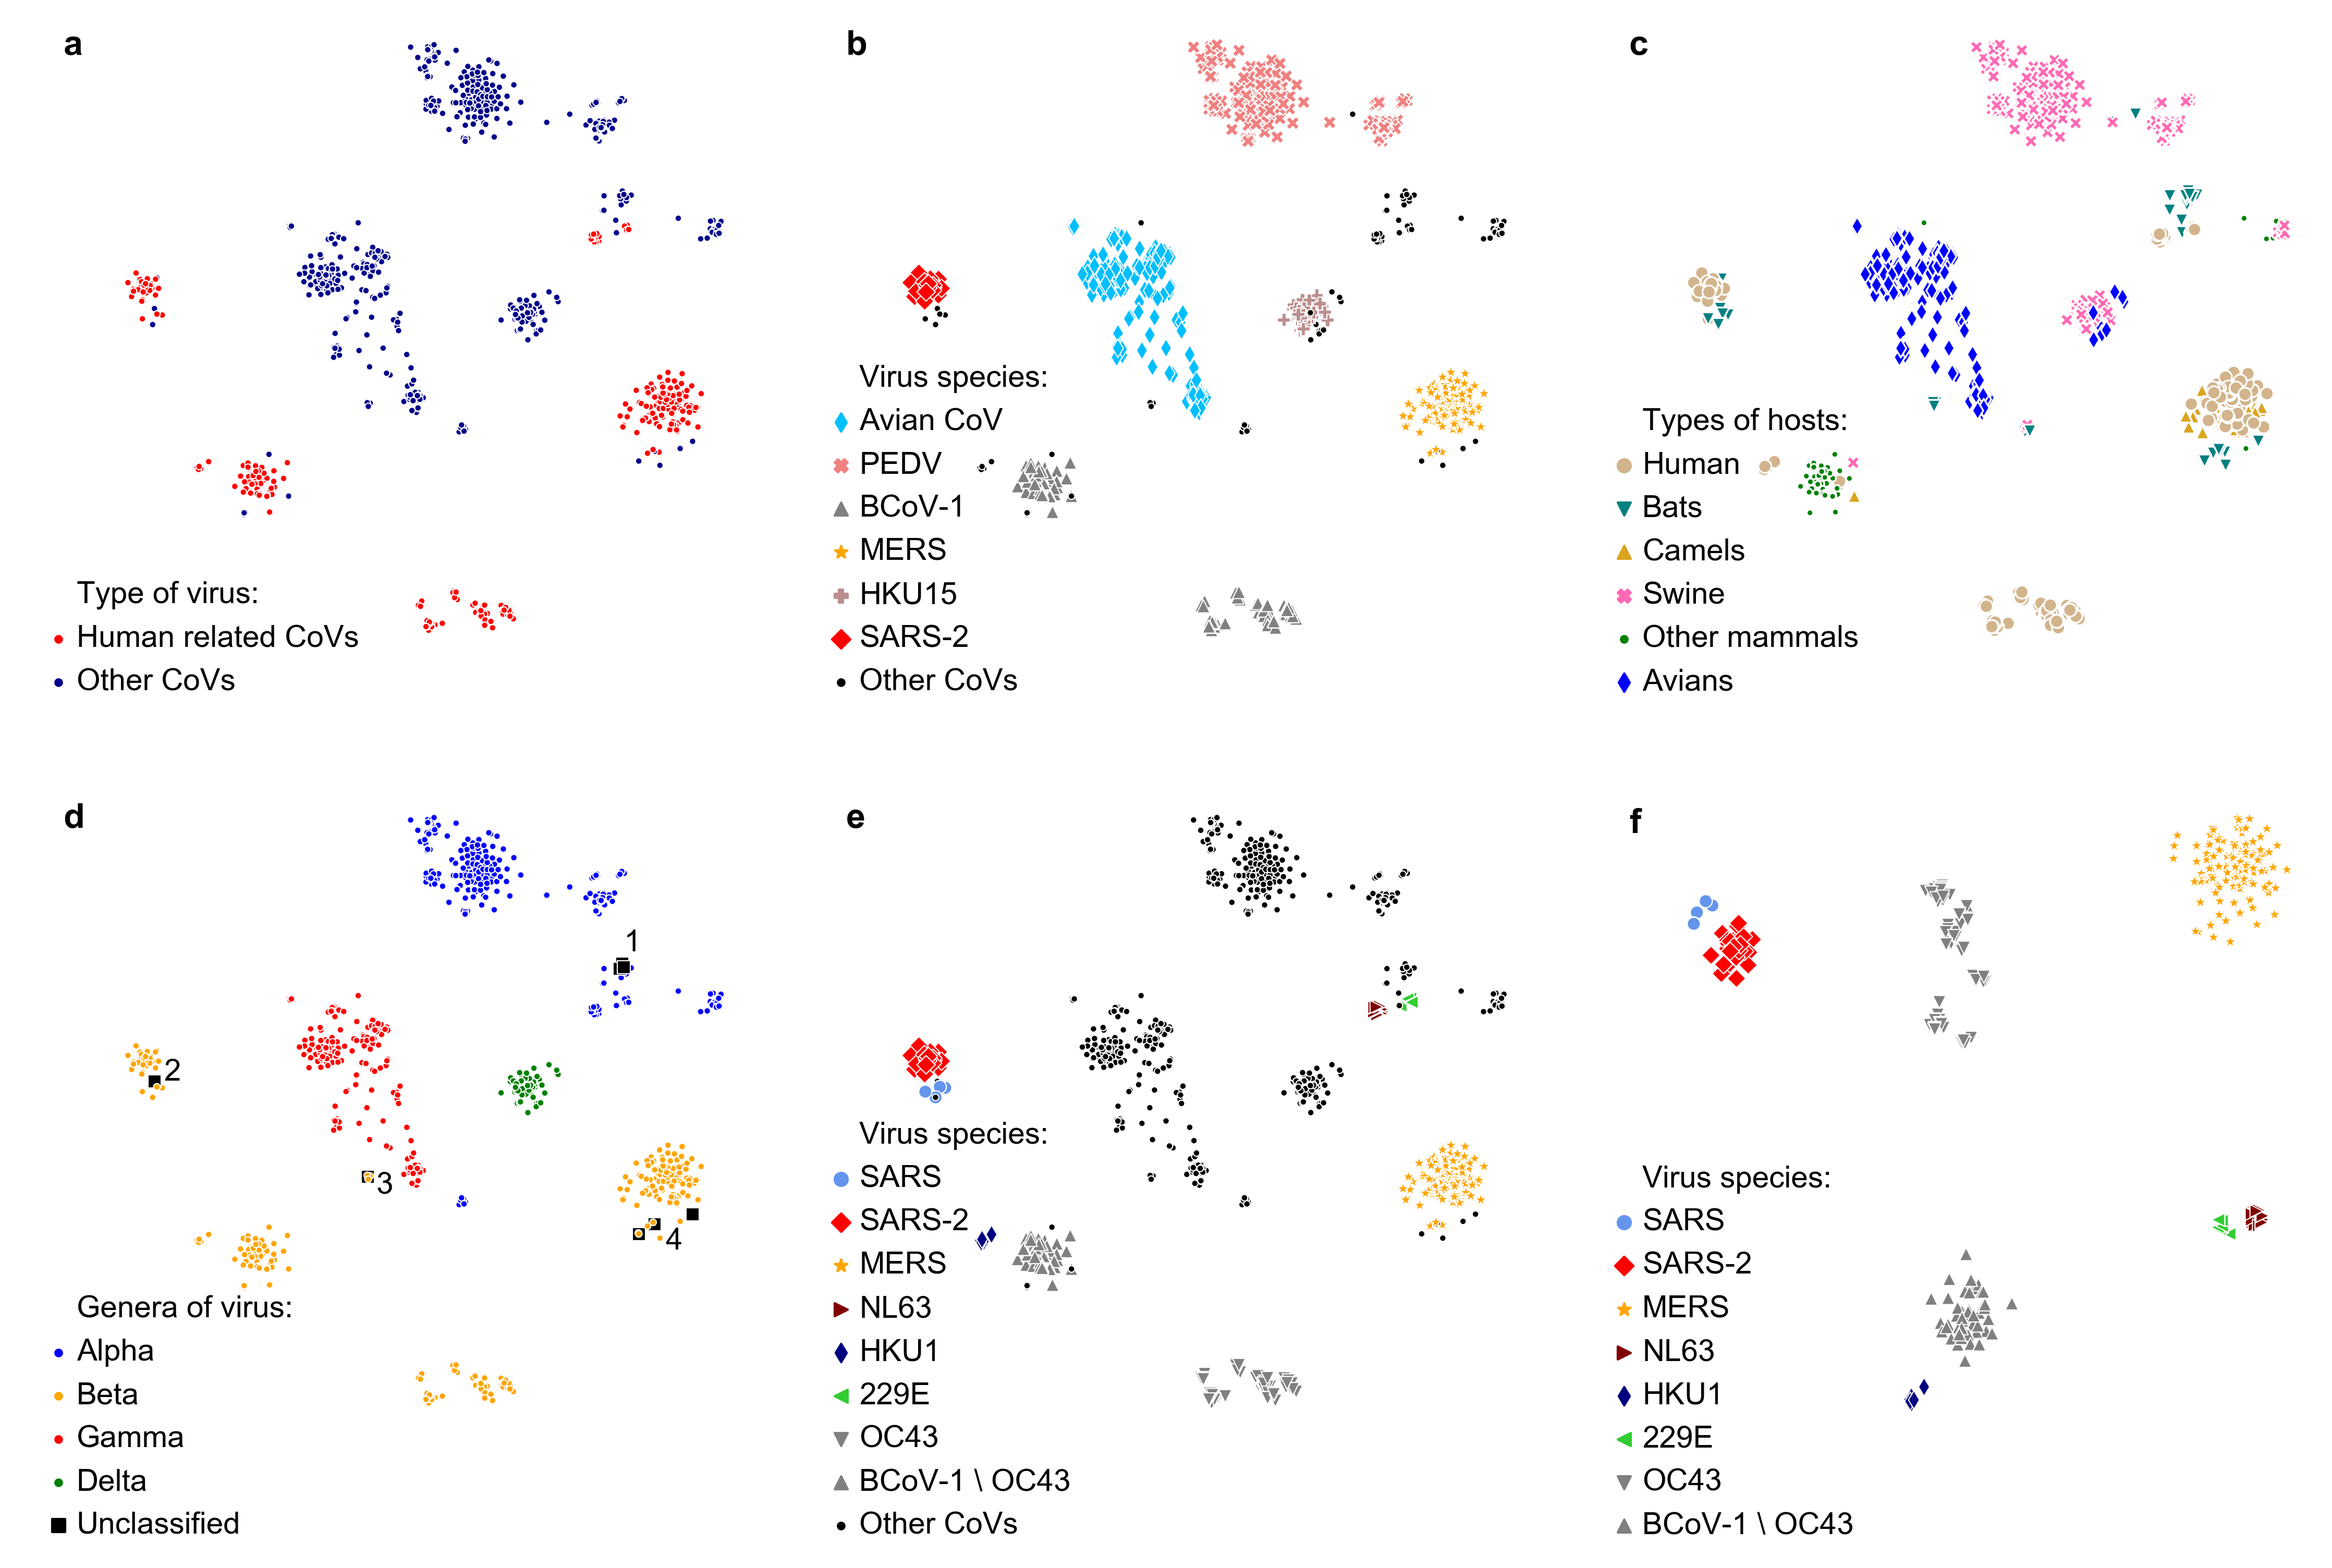

In [45]:
fig, ((ax11, ax12, ax13),(ax21, ax22, ax23)) = plt.subplots(nrows=2, ncols=3, figsize=(18.3, 12), dpi=300)

picture = []

#########################1###########################
###### Human CoVs vs the other CoVs
#####################################################

targets_labels = []
for entry in sequences:
    if entry.target == 1:
        targets_labels.append("Human related CoVs")
    if entry.target == 0:
        if entry.virus_species == "NA":
            targets_labels.append("Unknown")
        else:
            targets_labels.append("Other CoVs")

# we set the order of appearance
order_Hr_vs_Other_CoVs =  ['Human related CoVs', 'Other CoVs']
ordered_markers_Hr_vs_Other_CoVs = {'Human related CoVs': '.', 'Other CoVs': '.'}
colors_Hr_vs_Other_CoVs = {'Human related CoVs' : 'red',  'Other CoVs' : 'darkblue'}


data_frame_Hr_vs_Other_CoVs = pd.DataFrame({'1st coordinate of the embedded vector': X_embedded[:,0], 
                           '2nd coordinate of the embedded vector': X_embedded[:,1], 
                           'Type of virus:': targets_labels})
picture_1 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Type of virus:', 
            hue_order = order_Hr_vs_Other_CoVs,
            markers = ordered_markers_Hr_vs_Other_CoVs,
            palette = colors_Hr_vs_Other_CoVs,
            data = data_frame_Hr_vs_Other_CoVs,
            legend = "full",
            ax = ax11,
            linewidth=0.5,
#           edgecolor = None, # bad idea
            style = 'Type of virus:')


picture.append(picture_1)

#########################2###########################
###### Top virus species
#####################################################

order_top_hosts =  ['Avian CoV', 'PEDV', 'BCoV-1', 'MERS', 'HKU15', 'SARS-2', 'Other CoVs']
ordered_markers_top_hosts = {'Avian CoV': 'd', 'SARS-2': 'D', 'MERS': '*', 
                               'HKU15': 'P',   'PEDV': 'X', 'BCoV-1': '^', 'Other CoVs': '.'}
colors_top_hosts = {'Avian CoV' : 'deepskyblue', 'PEDV' : 'lightcoral', 'BCoV-1' : 'grey',
                      'MERS' : 'orange', 'HKU15': 'rosybrown', 'SARS-2' : 'red',  
                      'Other CoVs' : 'black'}

data_frame_top_hosts = pd.DataFrame({'1st coordinate of the embedded vector': X_embedded[:,0], 
                           '2nd coordinate of the embedded vector': X_embedded[:,1], 
                           'Virus species:': viral_species_top})
picture_2 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Virus species:', 
            hue_order = order_top_hosts,
            markers = ordered_markers_top_hosts,
            palette = colors_top_hosts,
            data = data_frame_top_hosts,           
            legend = 'full',
            ax = ax12,
            linewidth=0.5,
            style = 'Virus species:')

picture.append(picture_2)


#########################3###########################
###### Top virus hosts
#####################################################


order_top_species =  ['Human', 'Bats', 'Camels', 'Swine', 'Other mammals', 'Avians']
ordered_markers_top_species = {'Human': 'o', 'Bats': 'v', 'Camels': '^',
                               'Swine': 'X', 'Other mammals': '.', 'Avians': 'd'}
colors_top_species = {'Human' : 'tan', 'Bats' : 'teal', 
                      'Camels' : 'goldenrod', 'Swine': 'hotpink', 'Other mammals': 'green', 'Avians' : 'blue'}


data_frame_top_species = pd.DataFrame({'1st coordinate of the embedded vector': X_embedded[:,0], 
                           '2nd coordinate of the embedded vector': X_embedded[:,1], 
                           'Types of hosts:': multi_targets})
picture_3 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Types of hosts:', 
            hue_order = order_top_species,
            markers = ordered_markers_top_species,
            palette = colors_top_species,
            data = data_frame_top_species,
            legend = "full",
            ax = ax13,
            linewidth=0.8,
            style = 'Types of hosts:')
 

picture.append(picture_3)

#########################4###########################
###### Genera of CoVs
#####################################################


order_genera =  ['Alpha','Beta','Gamma', 'Delta', 'Unclassified']
ordered_markers_genera = {'Alpha': '.', 'Beta': '.', 'Gamma': '.',
                           'Delta': '.',  'Unclassified': ','}
colors_genera = {'Alpha' : 'blue', 'Beta' : 'orange', 
                  'Gamma' : 'red', 'Delta': 'green', 'Unclassified': 'black'}


data_frame_coro_types = pd.DataFrame({'1st coordinate of the embedded vector': X_embedded[:,0], 
                           '2nd coordinate of the embedded vector': X_embedded[:,1], 
                           'Genera of virus:': coro_types})

picture_4 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Genera of virus:', 
            palette = colors_genera,
            hue_order = order_genera,
            markers = ordered_markers_genera,
            data = data_frame_coro_types,
            ax = ax21,
            legend = "full",
            linewidth=0.5,
            style = 'Genera of virus:')

picture.append(picture_4) 


#########################5###########################
###### The 7 human related CoVs among all CoVs
#####################################################

targets_the_7_in_all = [] 
for entry in sequences:
    if entry.target == 1:
        targets_the_7_in_all.append(entry.virus_species)
    else:
        targets_the_7_in_all.append("Other CoVs")
        
targets_the_7_in_all = rename_the_seven(targets_the_7_in_all)

for i in range(0, len(targets_the_7_in_all)):
    if targets_the_7_in_all[i] == 'BCoV-1':
        if sequences[i].host_species == "Human" and sequences[i].accession_number != "ACJ35486":
            targets_the_7_in_all[i] = 'OC43'
        elif sequences[i].accession_number == "AWW13511":
            targets_the_7_in_all[i] = 'OC43'
        else:
            targets_the_7_in_all[i] = 'BCoV-1 \\ OC43'  


# we set the order of appearance of human related CoVs (HrCoVs)

order_HrCoVs =  ['SARS', 'SARS-2', 'MERS', 'NL63',  'HKU1', 
          '229E', 'OC43', 'BCoV-1 \\ OC43', 'Other CoVs']

ordered_markers_HrCoVs = {'SARS': 'o', 'SARS-2': 'D', 'MERS': '*', 
                   'NL63': '>',  'HKU1': 'd', '229E': '<', 'BCoV-1': '^', 
                   'OC43' : 'v', 'BCoV-1 \\ OC43': '^', 'Other CoVs': '.'}

colors_HrCoVs = {'SARS' : 'cornflowerblue', 'SARS-2' : 'red', 
          'MERS' : 'orange', 'NL63': 'maroon', 'HKU1': 'navy', 
          '229E' : 'limegreen', 'BCoV-1' : 'cyan', 'Other CoVs' : 'black',
          'OC43' : 'grey', 'BCoV-1 \\ OC43' : 'grey'}


data_frame = pd.DataFrame({'1st coordinate of the embedded vector': X_embedded[:,0], 
                           '2nd coordinate of the embedded vector': X_embedded[:,1], 
                           'Virus species:': targets_the_7_in_all})
picture_5 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Virus species:', 
            hue_order = order_HrCoVs,
            markers = ordered_markers_HrCoVs,
            palette = colors_HrCoVs,
            data = data_frame, 
            ax = ax22,
            legend = "full",
            linewidth=0.5,
            style = 'Virus species:')


picture.append(picture_5) 


#########################6###########################
###### The 7 human related CoVs among human related CoVs
#####################################################

order_HrCoVs =  ['SARS','SARS-2', 'MERS', 'NL63',  'HKU1', 
          '229E', 'OC43', 'BCoV-1 \\ OC43']

human_related_viral_species = [entry.virus_species for entry in human_related_sequences]
human_related_viral_species = rename_the_seven(human_related_viral_species)

for i in range(0, len(human_related_viral_species)):
    if human_related_viral_species[i] == 'BCoV-1':
        if human_related_sequences[i].host_species == "Human" and human_related_sequences[i].accession_number != "ACJ35486":
            human_related_viral_species[i] = 'OC43'
        else:
            human_related_viral_species[i] = 'BCoV-1 \\ OC43' 


data_frame = pd.DataFrame({'1st coordinate of the embedded vector': -X_embedded_human[:,1], 
                           '2nd coordinate of the embedded vector': -X_embedded_human[:,0], 
                           'Virus species:': human_related_viral_species})
picture_6 = sns.scatterplot(x = '1st coordinate of the embedded vector', 
            y = '2nd coordinate of the embedded vector', 
            hue = 'Virus species:', 
            hue_order = order_HrCoVs,
            markers = ordered_markers_HrCoVs,
            palette = colors_HrCoVs,
            data = data_frame, 
            ax = ax23,
            legend = "full",
            linewidth=0.5,
            style = 'Virus species:')

picture.append(picture_6)


for i in [0,1,2]:
    picture[i].axis('off') 
    picture[i].legend(bbox_to_anchor=(-0.15, -0.1))

for i in [3,4,5]:
    picture[i].axis('off') 
    picture[i].legend(bbox_to_anchor=(-0.15, -0.21))
    
ax11.text(-68, 45, 'a', fontsize=16, weight='bold')
ax12.text(-68, 45, 'b', fontsize=16, weight='bold')
ax13.text(-68, 45, 'c', fontsize=16, weight='bold')
ax21.text(-68, 45, 'd', fontsize=16, weight='bold')
ax22.text(-68, 45, 'e', fontsize=16, weight='bold')
ax23.text(-49, 19, 'f', fontsize=16, weight='bold')

ax21.text(27, 23, '1', fontsize=14)
ax21.text(-51, 0, '2', fontsize=14)
ax21.text(-15, -20, '3', fontsize=14) 
ax21.text(34, -30, '4', fontsize=14) 
    
plt.show()
fig.savefig('tSNE.eps')

## Cluster analysis

#### Intermixed clasters analysis for the top viral species

In [46]:
# Analysis of viral_species_top

# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, viral_species_top):
#     if x >= 0 and x <= 20 and y >= -10 and y <= 10:
#         if label != "Alpha":
#             print(label,seq.accession_number,seq.defline)

SARSr = SARS related

JTMC15|ANA96027 // SARSr-Rf-BatCoV JTMC15/R.ferrumequinum/Jilin/2013   <-- https://wwwnc.cdc.gov/eid/article/26/7/20-0092-t2

16BO133|ASO66810  <-- SARSr-Rf-BatCoV 16BO133/R.ferrumequinum/Korea/2016

BtCoV/BM48_31/BGR/2008|ADK66841  <-- SARSr-Rb-BatCoV BM48–31/BGR/2008/R.blasii/Bulgaria/2008


#### Intermixed clasters analysis for the 7 human related CoVs among all CoVs

In [47]:
# Analysis of the_7_in_all

# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, targets_the_7_in_all):
#     if x >= 15 and x <= 35 and y >= 10 and y <= 18:
#         print(label,x,y,seq.defline)

In [48]:
# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, targets_the_7_in_all):
#     if x >= -35 and x <= -25 and y >= -40 and y <= -20:
#         print(label,seq.accession_number,seq.defline)

In [49]:
# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, targets_the_7_in_all):
#     if x >= -60 and x <= -40 and y >= -5 and y <= 0:
#         print(label,seq.defline)

In [50]:
# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, targets_the_7_in_all):
#     if x >= -40 and x <= -20 and y >= -40 and y <= -20:
#         if label != "Alpha":
#             print(label,x,y,seq.defline)

In [51]:
# for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, targets_the_7_in_all):
#     if x >= 20 and x <= 50 and y >= -30 and y <= -5:
#         if label != "Alpha":
#             print(label,seq.accession_number,seq.defline)

#### Intermixed clasters analysis for genera of CoVs

In [52]:
#1
for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, coro_types):
    if x >= 10 and x <= 50 and y >= 10 and y <= 30:
        if label != "Alpha":
            print(label,seq.accession_number,seq.defline)

Unclassified QBP43256 BtCoV/Rh/YN2012_Rs3376|QBP43256|Bat|Bat_coronavirus
Unclassified QBP43268 BtCoV/Rh/YN2012_Rs4125|QBP43268|Bat|Bat_coronavirus
Unclassified QBP43279 BtCoV/Rh/YN2012_Rs4259|QBP43279|Bat|Bat_coronavirus
Unclassified QBP43290 BtCoV/Rh/YN2012_Ra13591|QBP43290|Bat|Bat_coronavirus


All are Alphas https://mbio.asm.org/content/mbio/11/3/e00760-20.full.pdf

In [53]:
#2
for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, coro_types):
    if x >= -60 and x <= -40 and y >= -10 and y <= 10:
        if label != "Beta":
            print(label,seq.accession_number,seq.defline)

Unclassified ANA96027 JTMC15|ANA96027|Bat|Bat_coronavirus
Unclassified ASO66810 16BO133|ASO66810|Bat|Bat_coronavirus


All are betas https://wwwnc.cdc.gov/eid/article/26/7/20-0092-t2

In [54]:
#3
for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, coro_types):
    if x >= -21 and x <= -15 and y >= -22 and y <= -15:
        if label != "Beta":
            print(label,x,y,seq.accession_number,seq.defline)

Unclassified -16.405994 -17.085835 QEH60463 BtCoV92|QEH60463|Bat|Bat_coronavirus


BtCoV92|QEH60463 is Nobecovirus (which is indeed in Betacoronaviruses) https://sfamjournals.onlinelibrary.wiley.com/doi/full/10.1111/lam.13285

In [55]:
#4
for x, y, seq, label in zip(X_embedded[:,0],X_embedded[:,1],sequences, coro_types):
    if x >= 20 and x <= 50 and y >= -40 and y <= 0:
        if label != "Beta":
            print(label,seq.accession_number,seq.defline)

Unclassified ANA96039 JPDB144|ANA96039|Bat|Bat_coronavirus
Unclassified ARJ34226 PREDICT/PDF_2180|ARJ34226|Bat|Bat_coronavirus
Unclassified BBJ36008 Vs_CoV_1|BBJ36008|Bat|Bat_coronavirus


# How we assess the performance

In [56]:
# Statictical parameters for the performance of a classifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def scores(y_test, y_predicted, print_scores = True):  
    precision = precision_score(y_test, y_predicted, pos_label = None,
                                    average = 'weighted')             
    recall = recall_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    if print_scores == True:
        print("accuracy = %.4f, f1 = %.4f, precision = %.4f, recall = %.4f" % (accuracy, f1, precision, recall))
    return accuracy, f1, precision, recall

In [57]:
# Confusion matrix

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.spring):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 26)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    
    fmt = '.2f' if normalize else 'd'
    
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    

    plt.ylabel('True labels', fontsize = 24)
    plt.xlabel('Predicted labels', fontsize = 24)
    
    
    # this is just a fix for the mpl bug that cuts off top/bottom of the heatmap matrix
    # this fix is not needed for kaggle
    if cwd != '/kaggle/working':
        bottom, top = plt.ylim() # current values for bottom and top
        bottom += 0.5 # change the bottom
        top -= 0.5 # change the top
        plt.ylim(bottom, top) # update the values

    return plt

#### Dictionary of classifiers

In [58]:
# this is our dicrionary of classifiers

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

our_dictionary_of_classifiers = {"SVM": SVC(probability = True, gamma = 'scale', random_state = 42), 
                                 "Logistic Regression": LogisticRegression(C = 30.0, class_weight = 'balanced', 
                                                                           solver = 'newton-cg', multi_class = 'multinomial', 
                                                                           n_jobs = -1, random_state = 42),
                                 "Decision Tree": DecisionTreeClassifier(random_state = 42),
                                 "Random Forest": RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 15, 
                                                                         n_jobs= -1, random_state = 42)}

In [59]:
# Receiver operating characteristic (ROC) curve

from sklearn.metrics import roc_curve

def ROC_curve(xTrain, xTest, yTrain, yTest,
              list_of_chosen = ["SVM"],
              dictionary_of_classifiers = our_dictionary_of_classifiers):
    
    # preparing the figure for plotting the ROC Curves
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 8))
    plt.plot([0, 1], [0, 1], color = 'blue', linestyle = '--', label = 'Flip a coin')
   
    # calculating the ROC Curves

    for name, classifier in dictionary_of_classifiers.items():
        if name in list_of_chosen:
            classifier.fit(xTrain, yTrain)
            # predict_proba gives the probabilities for the target 
            # (0 and 1 in our case) as a list (array). 
            # The number of probabilities for each row is equal 
            # to the number of categories in target variable (2 in our case).
            probabilities = classifier.predict_proba(xTest)
            probability_of_ones = probabilities[:,1] 
            # roc_curve returns:
            # - false positive rates (FP_rates), i.e., 
            # the false positive rate of predictions with score >= thresholds[i]
            
            # - true positive rates (TP_rates), i.e., 
            # the true positive rate of predictions with score >= thresholds[i]
            
            # - thresholds 
            FP_rates, TP_rates, thresholds = roc_curve(yTest, probability_of_ones)
            # plotting the ROC Curve to visualize all the methods
            plt.plot(FP_rates, TP_rates, label = name)
            
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('ROC Curve', fontsize = 14)
    plt.legend(loc = "lower right")
    plt.show()

In [60]:
# Box plot after CV-fold crossvalidation
from sklearn.model_selection import cross_validate

# this function returns a dataframe with  'accuracy', 'f1', 'sensitivity', 'specificity' 
# calculated within k-fold cross validation of a list of classifiers

# models = list of classifiers
# X = list of feature vectors
# y = list of labels
# models_names = custom names of the classifiers for the dataframe
# CV = number of folds in validation
# number_of_processors = number of processors used for peerforming the cross validation

# if number_of_processors = -1, all processors are used 
# (DISCLAIMER: it may cause a warning ``timeout or by a memory leak'') 

def Crossvalidating(X, y, CV = 5, list_of_chosen = ["SVM"], plotting = True, plot_name = "-fold",
                          dictionary_of_classifiers = our_dictionary_of_classifiers,
                          number_of_processors = 1):
    
                  
    table = pd.DataFrame(index = range(CV*len(list_of_chosen)))
    table_entries = []
    y_series = pd.Series(y)
    
    for name, classifier in dictionary_of_classifiers.items():
        if name in list_of_chosen:
            scoring = {'accuracy','f1','recall','balanced_accuracy'}
            scores = cross_validate(classifier, X, y_series, cv = CV, n_jobs = number_of_processors,
                                    scoring = scoring, return_train_score = False)
            accuracy = scores['test_accuracy']
            f1 = scores['test_f1']
            sensitivity = scores['test_recall']
            balanced_accuracy = scores['test_balanced_accuracy'] 
            # specificity = 2 * balanced_accuracy - sensitivity
            specificity = []
            for j in range(0,len(balanced_accuracy)):
                specificity.append(2*balanced_accuracy[j]-sensitivity[j])
            for j in range(0,len(balanced_accuracy)):
                table_entries.append((name, accuracy[j], f1[j], sensitivity[j], specificity[j]))
                
    table = pd.DataFrame(table_entries, columns = ['classifier', 'accuracy', 'F1', 'sensitivity', 'specificity'])
    
    if plotting == True:
        df_melted = pd.melt(table,id_vars = ['classifier'], 
                            value_vars = ['accuracy', 'F1', 'sensitivity', 'specificity'], 
                            var_name = 'scores')
        sns.boxplot(x = 'scores', y = 'value', data = df_melted, hue = 'classifier', palette = "Set3")
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        import time
        output_file_name = str(CV) + plot_name + '.png'
        if os.path.exists(output_file_name):
            plt.savefig(output_file_name.format(int(time.time())), bbox_inches = "tight")
        else:
            plt.savefig(output_file_name, bbox_inches = "tight")
        plt.clf()
    
    return table

# CLASSIFIERS

In [61]:
def Classifying(xTrain, xTest, yTrain, yTest,
                list_of_chosen = ["SVM"],
                dictionary_of_classifiers = our_dictionary_of_classifiers,
                report_stats = True,
                conf_matr = True, classes = ['Not the 7','The 7']):
    fitted_classifiers = {}
    for name, classifier in dictionary_of_classifiers.items():
        if name in list_of_chosen:
            classifier.fit(xTrain, yTrain)
            y_predicted = classifier.predict(xTest) 
            fitted_classifiers[name] = classifier
            if report_stats == True:
                print("Results for " + str(name))
            # report accuracy, f1, precision, recall for the classifier
            accuracy, f1, precision, recall = scores(yTest, y_predicted, print_scores = report_stats)
            
            if conf_matr == True:
                # The confusion matrix for the test data
                cm = confusion_matrix(yTest, y_predicted)
                fig = plt.figure(figsize=(7, 7))
                plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix\n for ' + str(name))
                plt.show()
    return fitted_classifiers  

In [62]:
our_list_of_classifiers = ["SVM","Logistic Regression","Decision Tree","Random Forest"]

In [63]:
import statistics

# Takes as an input the dataframe from the Clossvalidating functtion
# (It is the table with 'classifier', 'accuracy', 'F1', 'sensitivity', 'specificity' as colomns)

# For each classifier in our_list_of_classifiers, calculates another table with rows
# "mean accuracy", "std accuracy", "mean F1", "std F1",
# "mean sensitivity", "std sensitivity", "mean specificity", "std specificity"

def stast(stats_table, our_list_of_classifiers = our_list_of_classifiers):

    list_mean_accuracies = []
    list_stdev_accuracies = []
    list_mean_F1s = []
    list_stdev_F1s = []
    list_mean_sensitivities = []
    list_stdev_sensitivities = []
    list_mean_specificities = []
    list_stdev_specificities = []


    for classifier in our_list_of_classifiers:

        accuracy = list(stats_table.loc[stats_table['classifier'] == classifier]['accuracy'])
        list_mean_accuracies.append(statistics.mean(accuracy))
        list_stdev_accuracies.append(statistics.pstdev(accuracy))

        F1 = list(stats_table.loc[stats_table['classifier'] == classifier]['F1'])
        list_mean_F1s.append(statistics.mean(F1))
        list_stdev_F1s.append(statistics.pstdev(F1))    


        sensitivity = list(stats_table.loc[stats_table['classifier'] == classifier]['sensitivity'])
        list_mean_sensitivities.append(statistics.mean(sensitivity))
        list_stdev_sensitivities.append(statistics.pstdev(sensitivity)) 

        specificity = list(stats_table.loc[stats_table['classifier'] == classifier]['specificity'])
        list_mean_specificities.append(statistics.mean(specificity))
        list_stdev_specificities.append(statistics.pstdev(specificity))
    
    the_results = pd.DataFrame([list_mean_accuracies,list_stdev_accuracies,
                   list_mean_F1s,list_stdev_F1s,
                   list_mean_sensitivities,list_stdev_sensitivities,
                   list_mean_specificities,list_stdev_specificities],
                   columns = our_list_of_classifiers,
                   index = ["mean accuracy","std accuracy","mean F1","std F1",
                            "mean sensitivity","std sensitivity","mean specificity","std specificity"])
    return the_results

In [64]:
from sklearn.model_selection import KFold

def find_important_sites(our_sequences, our_targets, classifier = "Decision Tree",
                    n_splits = 5, shuffle = False, 
                    random_state = None, threshold = 0.0000):

    kf = KFold(n_splits, shuffle = shuffle, random_state = random_state)
    list_of_important_sites = []
    for train_index, test_index in kf.split(our_sequences,our_targets):
        xTrain, xTest = [our_sequences[i] for i in train_index],[our_sequences[j] for j in test_index]
        yTrain, yTest = [our_targets[i] for i in train_index],[our_targets[j] for j in test_index]
        dict_of_classifiers = Classifying(xTrain, xTest, yTrain, yTest, [classifier], 
                                          conf_matr = False, report_stats = False)
        important_sites = []
        for i, item in enumerate(dict_of_classifiers[classifier].feature_importances_):
            if item > threshold:
                important_sites.append((int(i/25)+1, i, item)) 
        list_of_important_sites.append(important_sites)
    return list_of_important_sites

In [65]:
# returns the dictionary of important sites and their average importance 
# and a full list of important sites in n_repeats * n_splits runs

def search_for_important_sites(X, y, classifier = "Decision Tree", n_repeats = 10, n_splits = 5, shuffle = True, 
                               random_state = None,  threshold = 0.0000, sorted_by_importance = True):
    total_list_of_important_sites = []
    for i in range(0,n_repeats):
        important_sites = find_important_sites(X, y, classifier = classifier, n_splits = n_splits, shuffle = shuffle, 
                                               random_state = random_state, threshold = threshold)
        total_list_of_important_sites.append(important_sites)
        
    flat_list = [item for sublist in total_list_of_important_sites for item in sublist]
    list_of_lists = [item for sublist in flat_list for item in sublist]
    set_of_sites = set()
    for item in list_of_lists:
        set_of_sites.add(item[0])
    dict_of_sites = {}

    for item in set_of_sites:
        dict_of_sites[item] = [0,0]

    for item in list_of_lists:
        dict_of_sites[item[0]][0] += item[2]
        dict_of_sites[item[0]][1] += 1

    for key, value in dict_of_sites.items():    
         dict_of_sites[key] = [value[0]/value[1],value[1]]
            
    sorted_dict = {k: v for k, v in sorted(dict_of_sites.items(), reverse=True, key=lambda item: item[1])}
    
    if sorted_by_importance == True:
        return sorted_dict, total_list_of_important_sites
    else:
        return dict_of_sites, total_list_of_important_sites

In [66]:
targets_without_BCoV_but_with_OC43 = []

for targ, label in zip(targets, targets_the_7_in_all):
    if label == 'BCoV-1 \\ OC43':
        targets_without_BCoV_but_with_OC43.append(0)
    else:
        targets_without_BCoV_but_with_OC43.append(targ)

In [67]:
# searches for important sites (print only those whose importance in >= threshold = 0.13)

file = open("important_sites_NO_BCoV_at_all.txt", "a+")

n_repeats = 10

# encoded_sequences, targets                                 <== for the 7 vs not the 7 classification

# encoded_sequences_avian_vs_swine, targets_avian_vs_swine   <== for the Avians vs Swine classification

# encoded_sequences, targets_mammals                         <== for the Mammals vs Not mammals classification

# encoded_sequences, targets_SARS2                           <== for SARS2 vs other CoVs

# encoded_sequences, targets_without_BCoV_but_with_OC43      <== for true the 7 vs not the 7 classification

for i in [2,3,5,7,9,10]:
    print(i)
    sorted_dict, total_list_of_important_sites = search_for_important_sites(encoded_sequences,  targets, 
                                                                            classifier = "Decision Tree",
                                                                            n_repeats = n_repeats, n_splits = i, 
                                                                            shuffle = True, 
                                                                            random_state = None,  threshold = 0.13, 
                                                                            sorted_by_importance = True)
    
    file.write(str(i)+"-fold "+str(n_repeats)+" times: \n")
    file.write(str(sorted_dict)+"\n")
    file.write("details:\n"+str(total_list_of_important_sites)+"\n\n")
        
file.close()

3


In [68]:
# For 3 classification ( the 7 vs the Not the 7, Avians vs Swine, Mammals vs Not mammals)
# performes k-fold crossvalidation for the classifiers in our_dictionary_of_classifiers
# and calculates 4 measures of performance: accuracy, F_1-score, sensitivity, and specificity

import matplotlib as mpl
mpl.rcParams['legend.handletextpad'] = 0.8

for number_of_folds in [2,3,5,7,9,10]:
    excel_file_name = str(number_of_folds) + '-fold(SVD-50).xlsx'
    
    print(str(number_of_folds) + '-fold for the 7 vs the Not the 7')   
    table_1 = Crossvalidating(X_50, targets, CV = number_of_folds, 
                          list_of_chosen = our_list_of_classifiers, plotting = True,
                          plot_name = "-fold-7_vs_Not7",
                          dictionary_of_classifiers = our_dictionary_of_classifiers,
                          number_of_processors = 1)
    the_results_1 = stast(table_1)
    with pd.ExcelWriter(excel_file_name, mode='a+') as writer:  
        table_1.to_excel(writer, sheet_name='7_vs_Not7')
        the_results_1.to_excel(writer, sheet_name='Stat-7_vs_Not7')
    
    print(str(number_of_folds) + '-fold for Avians vs Swine')  
    table_2 = Crossvalidating(X_50_avians_swines, targets_avian_vs_swine, CV = number_of_folds, 
                list_of_chosen = our_list_of_classifiers, plotting = True,
                plot_name = "-fold-Avians_vs_Swine",
                dictionary_of_classifiers = our_dictionary_of_classifiers,
                number_of_processors = 1)
    the_results_2 = stast(table_2)
    with pd.ExcelWriter(excel_file_name, mode='a') as writer:  
        table_2.to_excel(writer, sheet_name='Avians_vs_Swine')
        the_results_2.to_excel(writer, sheet_name='Stat-Avians_vs_Swine')

    print(str(number_of_folds) + '-fold for Mammals vs Not mammals')  
    table_3 = Crossvalidating(X_50, targets_mammals, CV = number_of_folds, 
                list_of_chosen = our_list_of_classifiers, plotting = True,
                plot_name = "-fold-Mam_vs_NotMam",
                dictionary_of_classifiers = our_dictionary_of_classifiers,
                number_of_processors = 1)
    the_results_3 = stast(table_3)
    with pd.ExcelWriter(excel_file_name, mode='a') as writer:  
        table_3.to_excel(writer, sheet_name='Mam_vs_NotMam')
        the_results_3.to_excel(writer, sheet_name='Stat-Mam_vs_NotMam')

2-fold for the 7 vs the Not the 7
2-fold for Avians vs Swine
2-fold for Mammals vs Not mammals
3-fold for the 7 vs the Not the 7
3-fold for Avians vs Swine
3-fold for Mammals vs Not mammals


<Figure size 432x288 with 0 Axes>